## Basic setup

[MLComp](https://github.com/catalyst-team/mlcomp) is a distributed DAG (Directed acyclic graph) framework for machine learning with UI. It helps to train, manipulate, and visualize.

Every machine learning pipeline is a Directed acyclic graph. [MLComp](https://github.com/catalyst-team/mlcomp) helps to execute it in a parallel manner, see the results via Web UI and manipulate the process easily.

https://github.com/catalyst-team/mlcomp

https://github.com/catalyst-team/catalyst

Install MLComp library. It already has Catalyst in the dependencies

In [1]:
#! pip install mlcomp

from mlcomp.utils.describe import describe, describe_task_names

Start MLComp's server

In [2]:
%%script bash --bg --out script_out

! mlcomp-server start

The sever has just started. If you run this code locally, you can open web browser and see the control panel: http://localhost:4201

## Catalyst/MLComp short tutorial

Catalyst has 2 API: 

1. python API, you are importing regular classes
2. config API, you are declaring an execution process in a special configuration file and run catalyst-dl run --config=PATH_TO_CONFIG

We use the second scenario. Let's have a look at our Catalyst config file

In [3]:
cat catalyst_mlcomp/configs/catalyst.yml

model_params:
  model: SegmentationModelPytorch
  num_classes: 4
  arch: Unet
  encoder: resnet34

args:
  expdir: "catalyst_segment"
  logdir: "log"

stages:

  data_params:
    num_workers: 8
    batch_size: 30
    per_gpu_scaling: True
    img_folder: 'data/input/train_images/'
    mask_folder: 'data/train_masks/'
    fold_csv: 'data/masks.csv'
    fold_number: 0

  state_params:
    main_metric: dice
    minimize_metric: False

  criterion_params:
    criterion: BCEDiceLoss
    
  callbacks_params:
    loss:
      callback: CriterionCallback
    optimizer:
      callback: OptimizerCallback
    saver:
      callback: CheckpointCallback
    dice:
      callback: DiceCallback

  stage1:
    state_params:
      num_epochs: 250

    optimizer_params:
      optimizer: Adam
      lr: 0.001
      layerwise_params:
        model.encoder*:
          lr: 0.00001
        model.decoder*:
          lr: 0.001

SegmentationModelPytorch here is a wrapper of this library: https://github.com/qubvel/segmentation_models.pytorch

We are declaring a model, stages, callbacks, criterion, number of epochs, etc. in a special configuration file.

Then, we could run it via catalyst-dl run --config=data/catalyst_config.yml

But instead of if, we are declaring one additional config for [MLComp](https://github.com/catalyst-team/mlcomp).

[MLComp](https://github.com/catalyst-team/mlcomp) helps to declare DAG and execute it in a parallel.

In [4]:
cat catalyst_mlcomp/configs/mlcomp.yml

info:
  name: manjaro_jupyterlab
  project: severstal
  layout: segment
  expdir: ../
executors:
  preprocess:
    type: preprocess
  masks:
    type: masks
    depends: preprocess
  train:
    type: catalyst
    gpu: 1
    args:
      config: configs/catalyst.yml
    depends: masks
    trace: trace.pth
    grid:
      - - encoder: resnet34
          batch_size: 28
        - encoder: se_resnext50_32x4d
          batch_size: 16
        - model_params:
            model: MobileUnet
            input_size: 256
            pretrained: True
            num_classes: 4
            layerwise_params: {}

You can see here:

1. basic info about DAG in info section

2. declaring DAG's structure in executors section.

DAG's element is known as Executor. They are here: preprocess, masks, train

Each executor must be declared somewhere in your project's folder where you are running ```mlcomp dag``` command

Preprocess is a standard group K-Fold stratification

In [5]:
cat catalyst_mlcomp/executors/preprocess.py

import pandas as pd

from mlcomp.contrib.split import stratified_group_k_fold
from mlcomp.worker.executors import Executor

@Executor.register
class Preprocess(Executor):
    def work(self):
        df = pd.read_csv('data/input/train.csv')
        df['exists'] = df['EncodedPixels'].notnull().astype(int)

        df['image_name'] = df['ImageId_ClassId'].map(
            lambda x: x.split('_')[0].strip()
        )
        df['class_id'] = df['ImageId_ClassId'].map(
            lambda x: int(x.split('_')[-1])
        )
        df['class_id'] = [
            row.class_id if row.exists else 0 for row in df.itertuples()
        ]
        df['fold'] = stratified_group_k_fold(
            label='class_id', group_column='image_name', df=df, n_splits=5
        )
        df.to_csv('data/fold.csv', index=False)


if __name__ == '__main__':
    Preprocess().work()

masks converts masks from csv file to regular png masks

In [6]:
cat catalyst_mlcomp/executors/masks.py

import os

import cv2
import pandas as pd
from tqdm import tqdm
import numpy as np

from mlcomp.contrib.transform.rle import rle2mask
from mlcomp.worker.executors import Executor


@Executor.register
class Masks(Executor):
    def work(self) -> dict:
        df = pd.read_csv('data/fold.csv')
        os.makedirs('data/train_masks', exist_ok=True)

        df = df.sort_values(by='ImageId_ClassId')
        size = (256, 1600)
        mask = np.zeros(size)
        res = []
        for row in tqdm(df.itertuples(), total=df.shape[0]):
            pixels = row.EncodedPixels
            if not isinstance(pixels, str):
                pixels = ''

            mask_cls = rle2mask(pixels, size[::-1])
            mask[mask_cls > 0] = row.class_id

            if row.ImageId_ClassId.endswith('_4'):
                img_id = row.ImageId_ClassId.split('.')[0].strip()
                cv2.imwrite(f'data/train_masks/{img_id}.png', mask)
                mask = np.zeros(size)

                res.append(
  

train executor is a standard executor declared in MLComp library. That is a wrapper of Catalyst.

## Severstal DAG execution

Start DAG

In [7]:
! mkdir -p ~/mlcomp/data/severstal/input

#! ln -s /data/ ~/mlcomp/data/severstal/input
#! ln -s /kaggle/working/ ~/mlcomp/db

In [8]:
! sleep 5
! mlcomp dag catalyst_mlcomp/configs/mlcomp_mobilenet_dpn92.yml 
#--params=executors/train/params/data_params/max_count:50 --params=executors/train/params/num_epochs:3
#resume: 'models/resnet34_first'

Describe the DAG execution status

In [9]:
describe_task_names(dag=1)

,id,name
0,1,preprocess
1,2,masks
2,3,model_params/model=MobileUnet model_params/input_size=256 model_params/pretrained=True model_params/num_classes=4
3,4,encoder=dpn98 batch_size=13
4,5,encoder=se_resnext50_32x4d batch_size=16


If you run this kernel, you will see an auto-refreshing describe panel below. (otherwise, you see only the last plot)

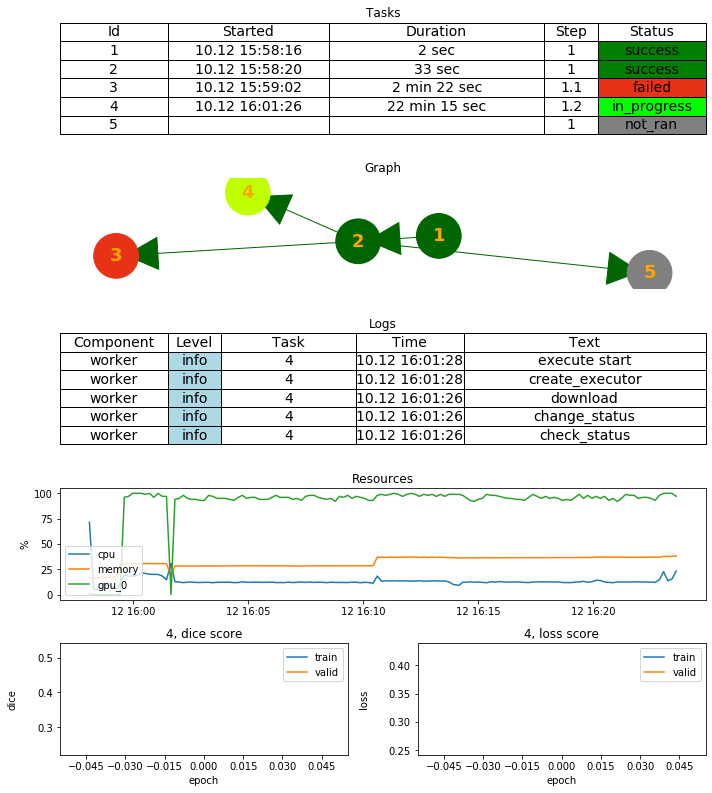

In [ ]:
describe(dag=1, metrics=['loss', 'dice'], wait=True, task_with_metric_count=3, fig_size=(10, 15))

## resnet34: ~ train: 0.82 valid:  0.79

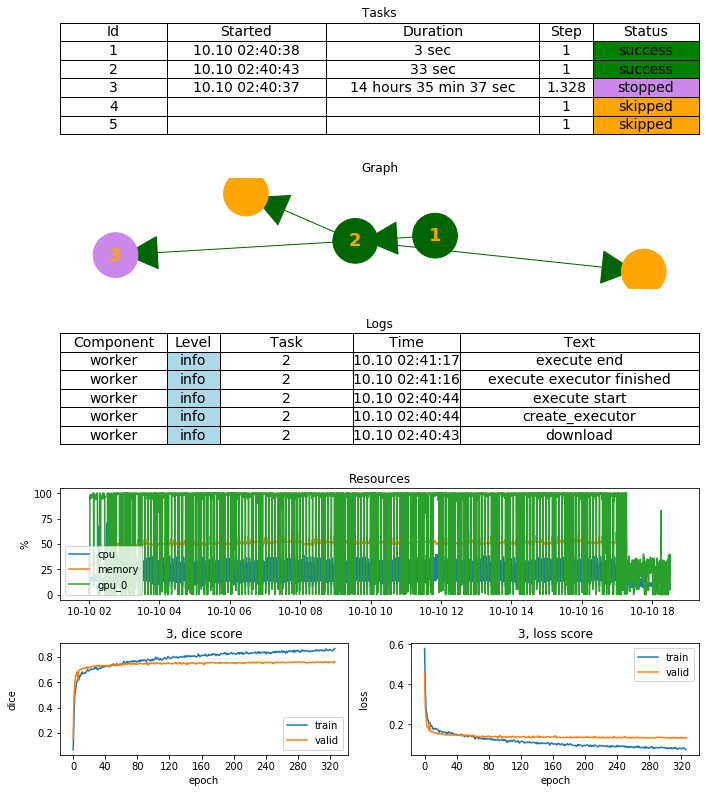

In [12]:
describe(dag=1, metrics=['loss', 'dice'], wait=True, task_with_metric_count=3, fig_size=(10, 15))

#### Copy result models

Catalyst has a special mechanism named tracing. You can combine a model and that weights in as a single file.

We have done it, actually. ( we declared ```trace``` configuration for train executor).